In [1]:
import os
from image_processing import *

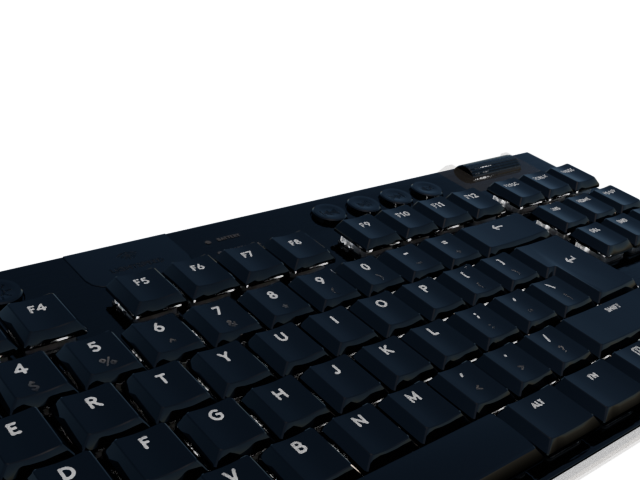

In [2]:
frame = 24

path = "keyboard_{'sun_intensity': 1.0, 'sun_elevation': 70.0, 'sun_rotation': 180.0, 'strength': 0.1}"
image = Image.open(f"datasets/segmentation/renders/{path}_{frame:03d}.png")
image

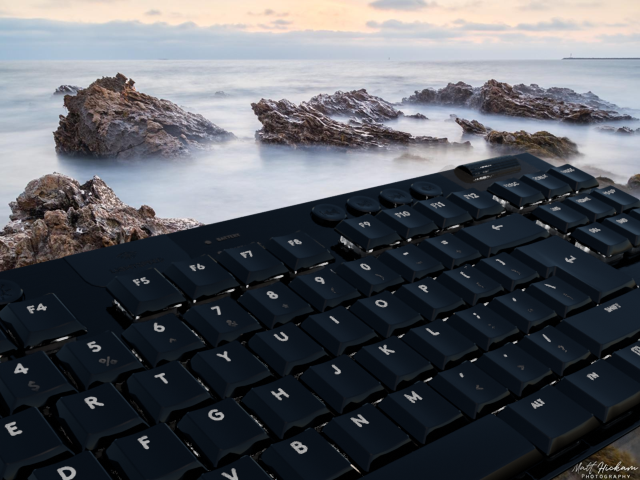

In [72]:
path = random.choice(os.listdir("assets/backgrounds"))
background = Image.open(f"assets/backgrounds/{path}")
background = background.resize(image.size)
background.paste(image, mask=image)
background = background.convert("RGBA")
background

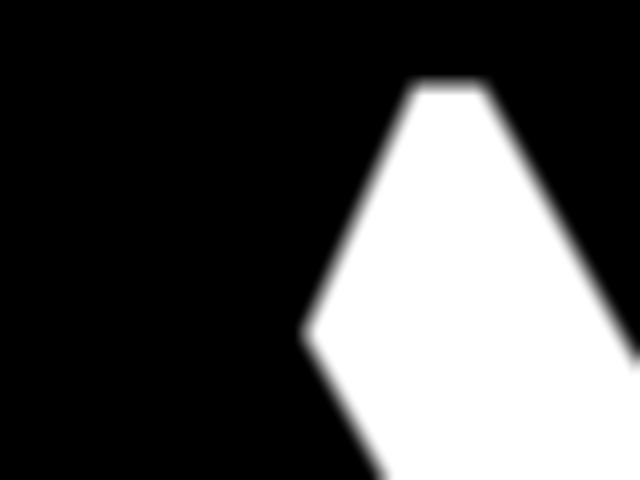

In [88]:
thickness = random.randint(100, 400)
blur = max(5, int(random.gauss(25, 10)))

alpha_mask = np.zeros((*background.size,), dtype="uint8")
cv.line(alpha_mask, (0, 0), background.size, (255,), thickness)

alpha_mask = apply_random_affine(alpha_mask)
alpha_img_transformed = Image.fromarray(alpha_mask)

alpha_mask = cv.blur(alpha_mask, (blur, blur))
alpha_img_final = Image.fromarray(alpha_mask)

alpha_mask = np.repeat(alpha_mask[:, :, np.newaxis], 4, axis=2)
alpha_mask = alpha_mask.astype("float32") / 255

alpha_img_final

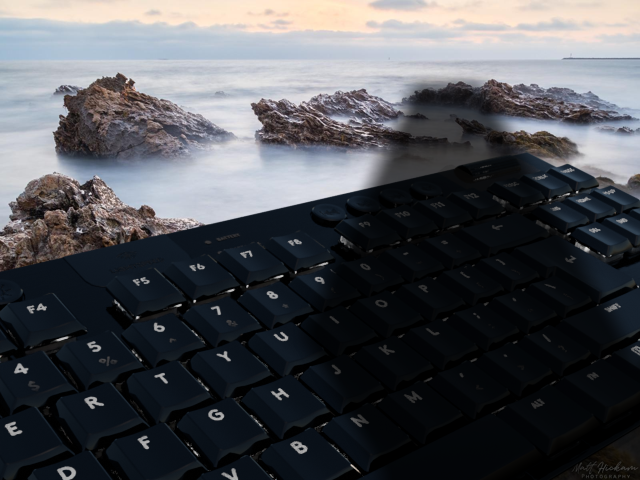

In [103]:
if random.random() > 0.5:
    exp = max(0.4, random.gauss(2.5, 1))
else:
    exp = max(0.4, random.gauss(0.5, 0.5))
exp = 0.3

bright_img = np.array(ImageEnhance.Brightness(background).enhance(exp))
img = alpha_mask * bright_img + (1 - alpha_mask) * background

Image.fromarray(img.astype("uint8"))

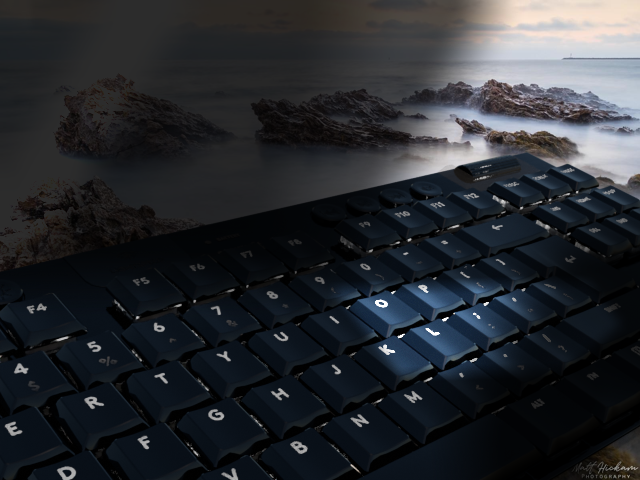

In [323]:
output = background.convert("RGBA")
overlay_funcs = (add_hard_overlay, add_soft_shadow)

n = np.random.geometric(0.5, (1,))[0] - 1
n = 5
for i in range(n):
    overlay_func = random.choice(overlay_funcs)
    output = overlay_func(output)

output

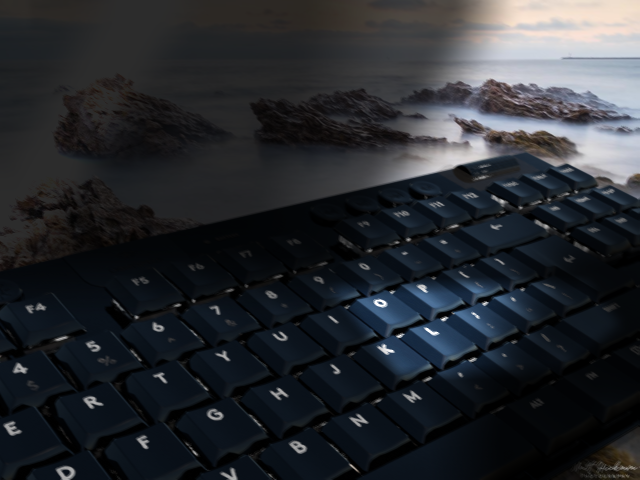

In [325]:
# Greater ksize = more motion blur
# Greater thickness = more gaussian blur

# TODO chromatic abberation

blur_kernel = get_motion_blur_kernel(theta=30, thickness=1, ksize=6)
blurred = cv.filter2D(np.array(output)[:, :, :3], ddepth=-1, kernel=blur_kernel)
Image.fromarray(blurred)

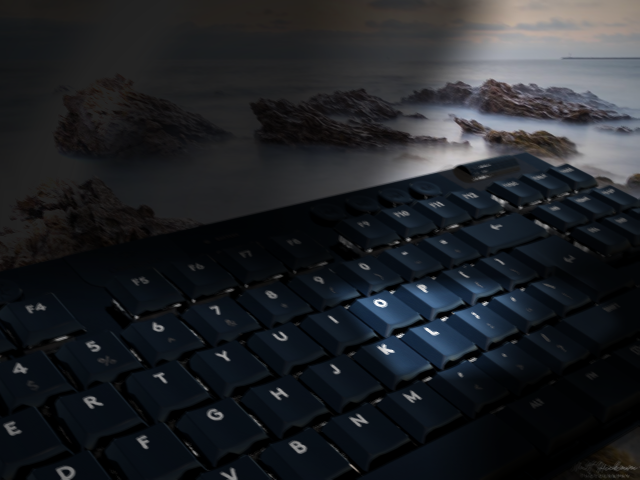

In [326]:
mask = get_vignette_kernel(400, image.size)
vignetted = (mask * blurred).astype("uint8")
vignetted = Image.fromarray(vignetted)
vignetted

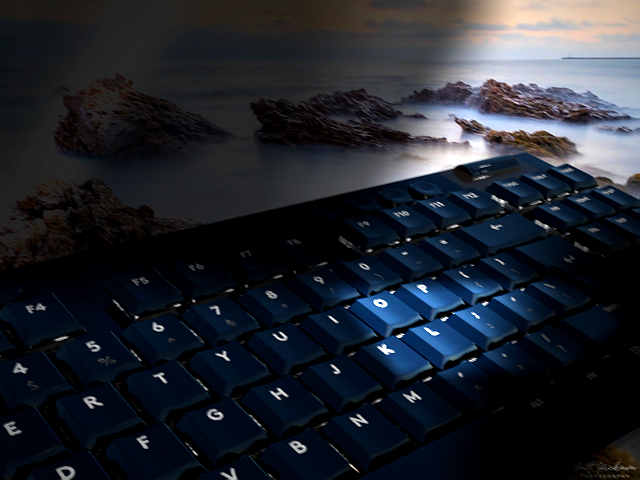

In [343]:
output = vignetted.copy()

contrast, exposure, sharpness, saturation = np.random.normal(loc=1.0, scale=0.5, size=4)
exposure = max(exposure, 0.4)
contrast = max(contrast, 0.2)

output = ImageEnhance.Contrast(output).enhance(contrast)
output = ImageEnhance.Brightness(output).enhance(exposure)
output = ImageEnhance.Sharpness(output).enhance(sharpness)
output = ImageEnhance.Color(output).enhance(saturation)
output